### Import modules & installations & data

In [93]:
import pandas as pd, numpy as np

# import re, catboost, gc
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import seaborn as sns
from tqdm import tqdm

# import lightgbm as lgb
# from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 100)


from feature_generation_funcs import *

In [94]:
df = (
    pd.read_excel(
        'train.xlsx'
    )
    .drop(
        columns=
        ['Unnamed: 0', 'Статус брони']
    )
    .set_index('№ брони')
)

df_test = (
    pd.read_excel("test.xlsx")
    .drop(columns="Unnamed: 0")
    .set_index('№ брони')
)

df['target'] = np.where(df['Дата отмены'].isna(), 0, 1)
df.drop(columns = 'Дата отмены', inplace=True)

### Data processing & feature engineering for baseline

In [95]:
df_train = data_baseline_prepare_(df)
df_train = calendar_features_(df_train)
df_train = price_features_(df_train)


df_test = data_baseline_prepare_(df_test)
df_test = calendar_features_(df_test)
df_test = price_features_(df_test)


cols_to_drop = [
    "booking_date_dd_mm_yy",
    "booking_date_month_name",
    "check_in_date_dd_mm_yy",
    "check_out_date_dd_mm_yy",
]


df_train.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=cols_to_drop, inplace=True)

in 13 >>> processing... >>> out 27


100%|██████████| 26174/26174 [00:00<00:00, 702391.68it/s]

in 27 >>> processing... >>> out 35


in 12 >>> processing... >>> out 26


100%|██████████| 11218/11218 [00:00<00:00, 688605.16it/s]

in 26 >>> processing... >>> out 34


In [96]:
# df_train['baseline07'] = pd.read_csv('baseline07_neuro_scores.csv', header=None).values
# df_test['baseline07'] = pd.read_csv('baseline07_proba.csv', header=None).values

In [97]:
object_columns = list(df_train.select_dtypes(include='object').columns)

In [98]:
def label_encoding(train_df, test_df, cols):
    
    label_dict = {}
    
    for col in cols:
        unique_values = train_df[col].unique()
        label_mapping = {val: idx for idx, val in enumerate(unique_values)}
        
        label_dict[col] = label_mapping
        
    for col in cols:
        train_df[col] = train_df[col].map(label_dict[col])
        test_df[col] = test_df[col].map(label_dict[col])
    
    
    return train_df, test_df

In [99]:
import category_encoders as ce

def hashing_enc(train_df, test_df, cols):

    encoder = ce.HashingEncoder(cols=cols, n_components=50)
    encoder.fit(train_df[cols])

    encoded_train_df = encoder.transform(train_df[cols])
    encoded_test_df = encoder.transform(test_df[cols])

    train_df = pd.concat([train_df.drop(columns=cols), encoded_train_df], axis=1)
    test_df = pd.concat([test_df.drop(columns=cols), encoded_test_df], axis=1)

    return train_df, test_df

In [100]:
df_train, df_test = hashing_enc(df_train, df_test, object_columns)

In [101]:
cols_to_drop = ['Дата бронирования', 'Заезд', 'Выезд', 'Источник_agg', 'Категория_номера_agg']
df_train.drop(columns=cols_to_drop, inplace=True)
df_test.drop(columns=cols_to_drop, inplace=True)

In [102]:
X = df_train.drop(columns='target')
y = df_train['target']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=42, stratify=y
# )

In [103]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

def nn_datasets_assembling(X_train, y_train, X_test, y_test, batch_size=32):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, y_train_tensor, y_test_tensor, X_train_scaled.shape[1], scaler  

In [104]:
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class MLP_Wide(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Wide, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    


class MLP_Wide_v2(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Wide_v2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    



class MLP_Wide_v3(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Wide_v3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    
class MLP_Wide_v4(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Wide_v4, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(0.3),            
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class MLP_Wide_v5(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Wide_v5, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization после Linear
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 1024),
            # nn.BatchNorm1d(1024),  # Batch Normalization после Linear
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization после Linear
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 1),
            nn.Sigmoid()  # Для бинарной классификации
        )

    def forward(self, x):
        return self.model(x)


class MLP_DeepDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLP_DeepDropout, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class MLP_WideDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLP_WideDropout, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [105]:
import torch.nn.init as init

from torch.optim.lr_scheduler import StepLR

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.constant_(m.bias.data, 0)

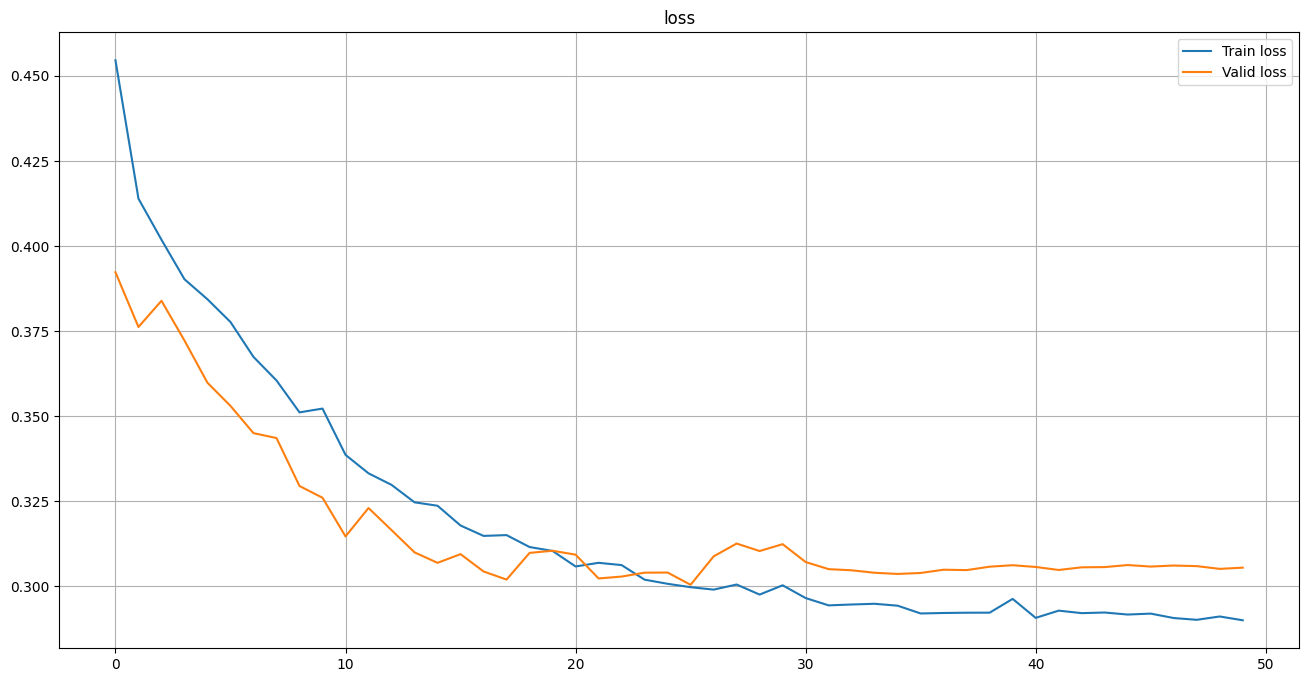

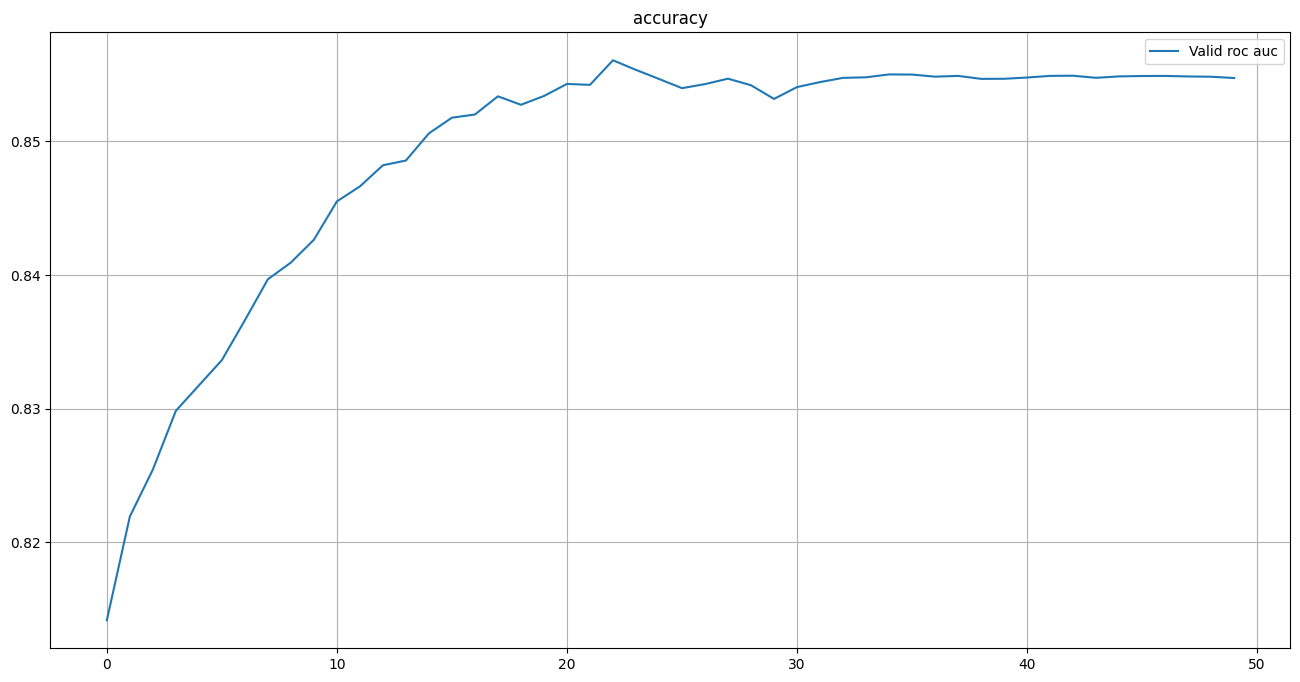

Epoch 50/50, Train Loss: 0.2900, Val Loss: 0.3055, ROC-AUC: 0.8547


In [106]:
from sklearn.model_selection import KFold, StratifiedKFold
import copy

# List to store the models trained on each fold
models = []

# Initialize KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

num_epochs = 50
criterion = nn.BCELoss()
from IPython.display import clear_output

roc_auc_scores_folds = []

# Prepare the dataset
X_np = X.values  # Преобразование данных в numpy
y_np = y.values

# K-fold training
for fold, (train_idx, val_idx) in enumerate(kf.split(X_np, y_np)):
    print(f"Fold {fold + 1}/{kf.get_n_splits()}")
    
    # Split the data for this fold
    X_train_fold, X_val_fold = X_np[train_idx], X_np[val_idx]
    y_train_fold, y_val_fold = y_np[train_idx], y_np[val_idx]
    
    # Create data loaders for this fold
    train_loader, val_loader, y_train_tensor, y_val_tensor, input_dim, scaler = nn_datasets_assembling(
        X_train_fold, pd.Series(y_train_fold), X_val_fold, pd.Series(y_val_fold), batch_size=64
    )
    
    # Initialize model, optimizer, and scheduler
    model = MLP_Wide_v5(input_dim)  # Инициализация новой модели
    model.apply(initialize_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = StepLR(optimizer, step_size=30)
    
    # Train the model for this fold
    train_losses = []
    val_losses = []
    roc_auc_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        all_outputs = []
        all_targets = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch.float())
                val_loss += loss.item() * X_batch.size(0)
                all_outputs.append(outputs.cpu().numpy())
                all_targets.append(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        roc_auc = roc_auc_score(all_targets, all_outputs)
        roc_auc_scores.append(roc_auc)
        
        clear_output()
        plot_stats(train_losses, val_losses, roc_auc_scores)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ROC-AUC: {roc_auc:.4f}')
        
        scheduler.step()
    
    # Save the model after training this fold
    models.append(copy.deepcopy(model))
    roc_auc_scores_folds.append(roc_auc)

In [108]:
np.array(roc_auc_scores_folds).mean()

np.float64(0.8483240681578732)

In [ ]:
np.array(roc_auc_scores_folds).mean()

np.float64(0.851699984153884)

In [109]:
df_test_scaled = scaler.transform(df_test)
df_test_tensor = torch.tensor(df_test_scaled, dtype=torch.float32)
    
df_test_dataset = TensorDataset(df_test_tensor)
df_test_loader = DataLoader(df_test_dataset, batch_size=32)

/Users/kulyaskin_mikhail/PetProjects/PSB Hack/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [110]:
# Усредненные предсказания на тестовом наборе данных
test_preds_all_models = []

for model in models:
    model.eval()
    test_preds = []
    with torch.no_grad():
        for X_batch in df_test_loader:
            outputs = model(X_batch[0]).squeeze()
            test_preds.extend(outputs.cpu().numpy())
    test_preds_all_models.append(np.array(test_preds))

# Усреднение предсказаний всех 5 моделей
mean_test_preds = np.mean(test_preds_all_models, axis=0)

# Создание сабмишена
submission = pd.DataFrame(mean_test_preds)
submission.to_csv('nn_09.csv', header=None, index=False)

In [250]:
# train_loader, test_loader, y_train_tensor, y_test_tensor, input_dim, scaler = nn_datasets_assembling(X_train, y_train, X_test, y_test, batch_size=64)

In [252]:
# model = MLP_Wide_v5(input_dim)

In [253]:
# import torch.nn.init as init

# def initialize_weights(m):
#     if isinstance(m, nn.Linear):
#         # init.kaiming_normal_(m.weight.data, nonlinearity='relu')
#         init.xavier_normal_(m.weight.data)
#         if m.bias is not None:
#             init.constant_(m.bias.data, 0)

# model.apply(initialize_weights)

MLP_Wide_v5(
  (model): Sequential(
    (0): Linear(in_features=81, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [254]:
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
# from IPython.display import clear_output


# # Loss function and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=60)

# # Training loop with loss recording
# train_losses = []
# val_losses = []

# num_epochs = 100

# threshold = 0.5

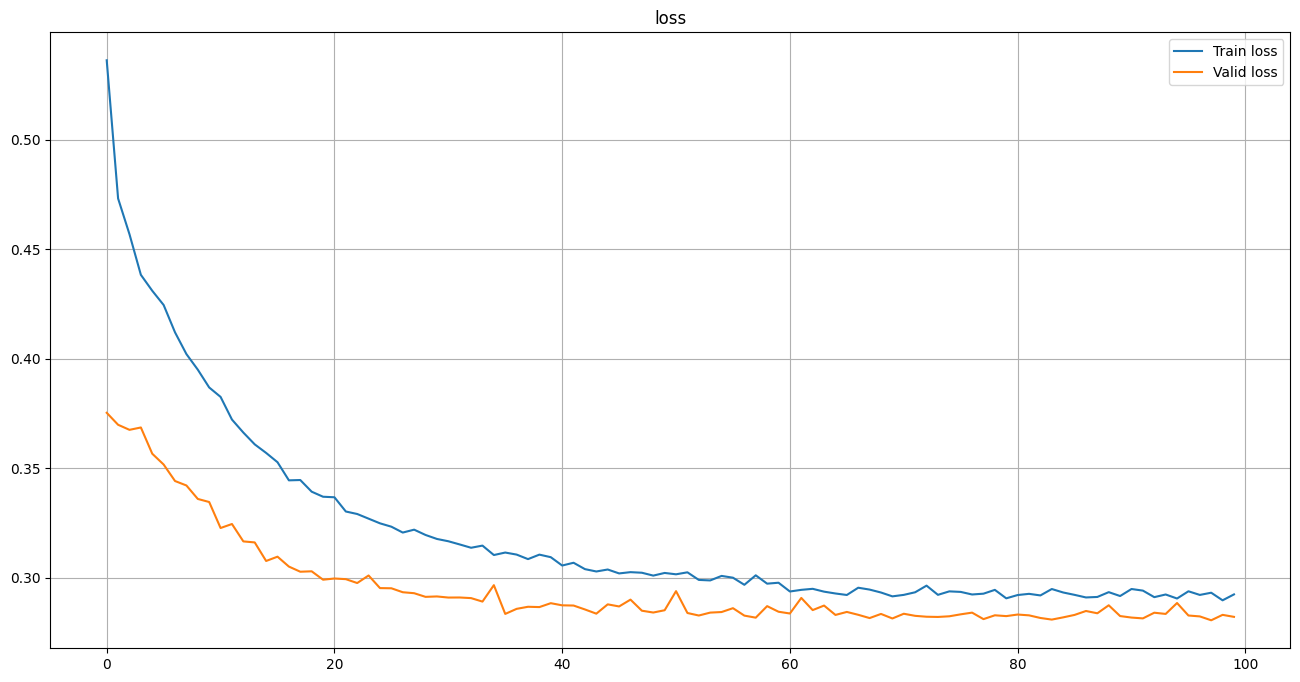

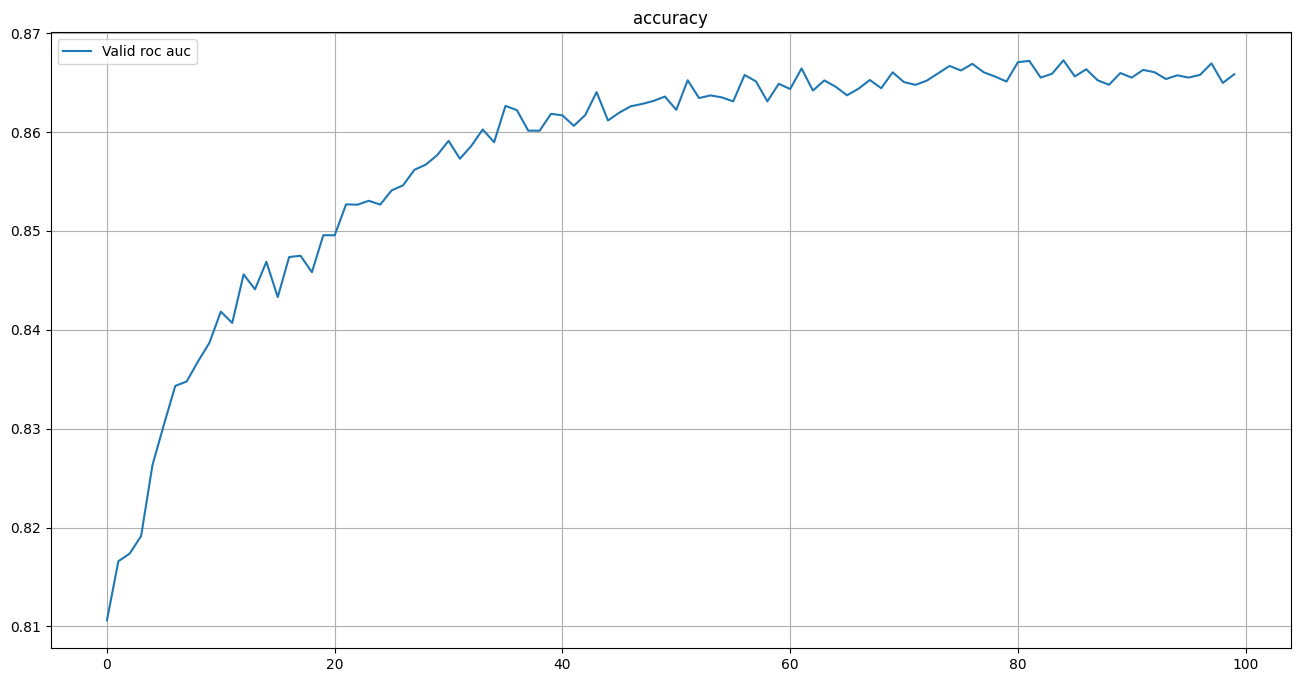

Epoch 100/100, Train Loss: 0.2925, Val Loss: 0.2822, ROC-AUC: 0.8658


In [255]:
# import torch
# from sklearn.metrics import roc_auc_score
# from IPython.display import clear_output

# # Your model and other initial setup

# train_losses = []
# val_losses = []
# roc_auc_scores = []

# threshold = 0.5

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for X_batch, y_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(X_batch).squeeze()
#         loss = criterion(outputs, y_batch.float())
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * X_batch.size(0)
    
#     train_loss /= len(train_loader.dataset)
#     train_losses.append(train_loss)

    
#     # Validation loop
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     all_outputs = []
#     all_targets = []
#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             outputs = model(X_batch).squeeze()
#             loss = criterion(outputs, y_batch.float())
#             val_loss += loss.item() * X_batch.size(0)
            
#             # Collecting predictions and true values for ROC-AUC
#             all_outputs.append(outputs.cpu().numpy())
#             all_targets.append(y_batch.cpu().numpy())
            
#             # For accuracy calculation (binary classification)
#             preds = (outputs >= threshold).long()
#             correct += (preds == y_batch).sum().item()
    
#     val_loss /= len(test_loader.dataset)
#     val_losses.append(val_loss)
    
#     # Flattening arrays for ROC-AUC computation
#     all_outputs = np.concatenate(all_outputs)
#     all_targets = np.concatenate(all_targets)

#     # Calculating ROC-AUC
#     roc_auc = roc_auc_score(all_targets, all_outputs)
#     roc_auc_scores.append(roc_auc)

#     clear_output()

#     plot_stats(train_losses, val_losses, roc_auc_scores)

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ROC-AUC: {roc_auc:.4f}')
    
#     scheduler.step()

In [256]:
# # Evaluation on the test set
# model.eval()
# all_preds = []
# all_preds_labels = []
# all_labels = []

# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         outputs = model(X_batch).squeeze()
#         preds_label = (outputs >= threshold).long()
#         preds = outputs
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(y_batch.cpu().numpy())
#         all_preds_labels.extend(preds_label.cpu().numpy())

# # Calculate F1 score
# roc_auc = roc_auc_score(all_labels, all_preds)
# print(f'Test roc_auc Score: {roc_auc:.4f}')

Test roc_auc Score: 0.8658


In [257]:
# Test roc_auc Score: 0.8626 nn_03
# Test roc_auc Score: 0.8658 nn_04

In [258]:
# df_test_scaled = scaler.transform(df_test)
# df_test_tensor = torch.tensor(df_test_scaled, dtype=torch.float32)
    
# df_test_dataset = TensorDataset(df_test_tensor)
# df_test_loader = DataLoader(df_test_dataset, batch_size=32)

In [259]:
# model.eval()
# all_preds = []

# with torch.no_grad():
#     for X_batch in df_test_loader:
#         outputs = model(X_batch[0]).squeeze()
#         preds = outputs
#         all_preds.extend(preds.cpu().numpy())


# submission = pd.DataFrame(all_preds)
# submission.to_csv('nn_04.csv', header=None, index=False)

In [ ]:
# public test nn_03 0.8426
# public test nn_04 0.8442

In [267]:
# df_train_scaled = scaler.transform(df_train.drop(columns=['target']))
# df_train_tensor = torch.tensor(df_train_scaled, dtype=torch.float32)
    
# df_train_dataset = TensorDataset(df_train_tensor)
# df_train_loader = DataLoader(df_train_dataset, batch_size=32)

In [268]:
# model.eval()
# all_preds = []

# with torch.no_grad():
#     for X_batch in df_train_loader:
#         outputs = model(X_batch[0]).squeeze()
#         preds = outputs
#         all_preds.extend(preds.cpu().numpy())


# submission = pd.DataFrame(all_preds)
# submission.to_csv('nn_04_train.csv', header=None, index=False)